***Loading the DeepCell Segmentation and the original Mask***

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from skimage.color import label2rgb
from scipy.ndimage import center_of_mass
from tqdm import tqdm
from sklearn.cluster import KMeans

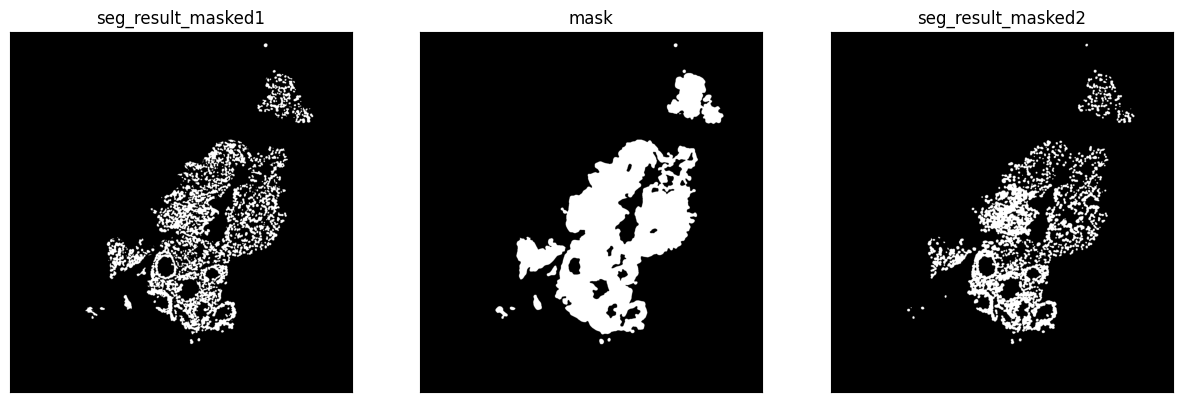

In [20]:
segmentation1='/nfs2/baos1/rudravg/DeepCell_Results/GCA112TIA_DAPI_DAPI_30ms_ROUND_00_initial_reg.tif'
segmentation2='/nfs2/baos1/rudravg/registration/registration_GCA112TIA/affine/DeepCell_Results/GCA112TIA_DAPI_DAPI_12ms_ROUND_19_initial_reg.tif'

seg_result1 = np.array(Image.open(segmentation1))
seg_result2 = np.array(Image.open(segmentation2))

mask='/nfs2/baos1/rudravg/Retention_Masks/GCA112TIA_TISSUE_RETENTION.tif'
mask=np.array(Image.open(mask))
mask = (mask > 0).astype(int)
seg_result1 = (seg_result1 > 0).astype(int)
seg_result2 = (seg_result2 > 0).astype(int)

seg_result_masked1 = seg_result1 * mask
seg_result_masked2 = seg_result2 * mask

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot seg_result
axes[0].imshow(seg_result_masked1, cmap='gray')
axes[0].set_title('seg_result_masked1')

# Plot mask
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('mask')

# Plot seg_result_masked
axes[2].imshow(seg_result_masked2, cmap='gray')
axes[2].set_title('seg_result_masked2')

# Remove the x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


***Connected Components***

In [21]:
labeled1, num_labels1 = label(seg_result_masked1)
labeled2, num_labels2 = label(seg_result_masked2)

print(f"Number of connected components: {num_labels1}")
print(f"Number of connected components: {num_labels2}")

Number of connected components: 457
Number of connected components: 319


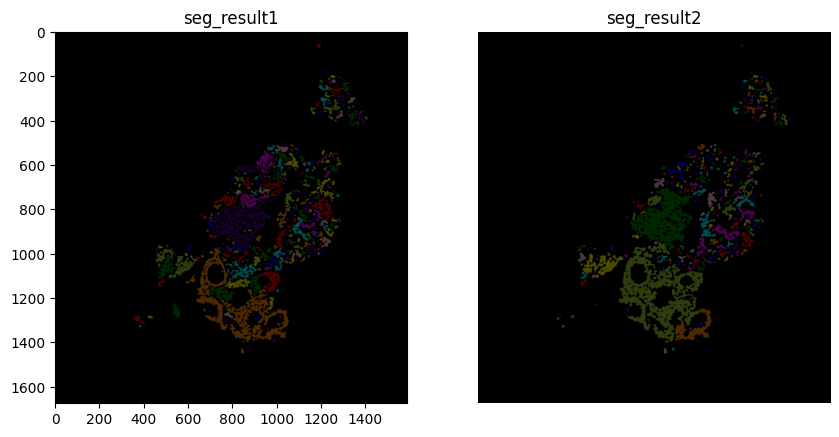

In [22]:
# Create an RGB image from the labeled array
image_label_overlay1 = label2rgb(labeled1, image=seg_result_masked1, bg_label=0)
image_label_overlay2 = label2rgb(labeled2, image=seg_result_masked2, bg_label=0)
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Create a figure
axes[0].imshow(image_label_overlay1)
axes[0].set_title('seg_result1')

# Plot mask
axes[1].imshow(image_label_overlay2)
axes[1].set_title('seg_result2')
plt.axis('off')

plt.show()

***Centroid Calculation for each connected component***

In [23]:
def compute_centroids(labeled, num_labels):
    indices = np.indices(labeled.shape).reshape(labeled.ndim, -1)
    labels = labeled.ravel()
    return np.array([np.mean(indices[:, labels == i], axis=1) for i in tqdm(range(1, num_labels + 1))])

centroids1 = compute_centroids(labeled1, num_labels1)
centroids2 = compute_centroids(labeled2, num_labels2)

  0%|          | 0/457 [00:00<?, ?it/s]

100%|██████████| 319/319 [00:01<00:00, 235.11it/s]


100%|██████████| 457/457 [00:00<00:00, 699.27it/s]


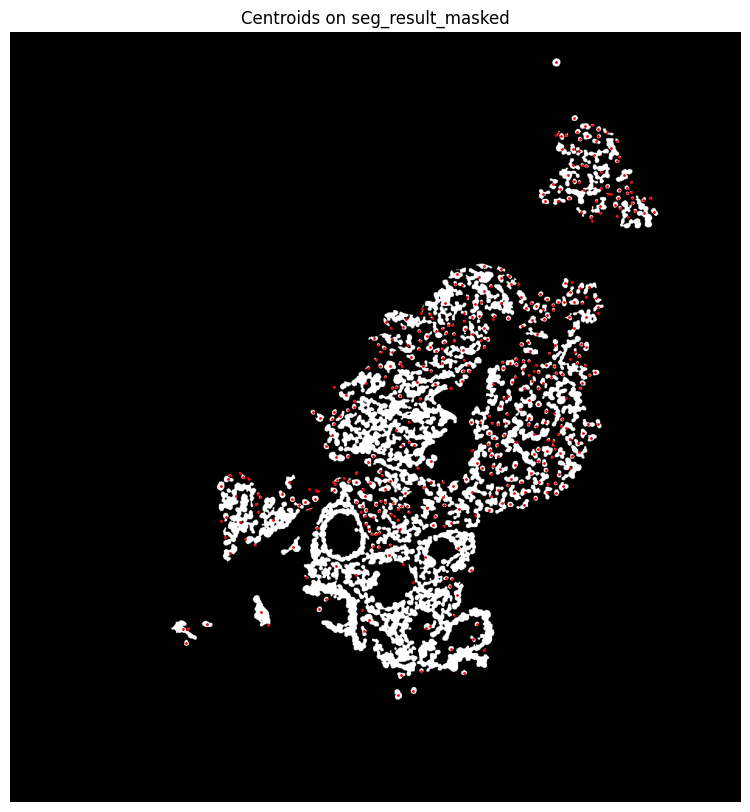

In [24]:
plt.figure(figsize=(10, 10))

# Visualize the seg_result_masked
plt.imshow(seg_result_masked1, cmap='gray')

# Plot all of the centroids
for y, x in tqdm(centroids1):
    plt.scatter(x, y, c='r',s=1)

plt.title('Centroids on seg_result_masked')
plt.axis('off')

plt.show()

***Centroid Distance for each connected component***

In [16]:
differences = [np.abs(np.array(centroid1) - np.array(centroid2)) for centroid1, centroid2 in tqdm(zip(centroids1, centroids2))]
# Calculate the mean of the differences
mean_difference = np.mean(differences)

print(f"Mean difference between centroids: {mean_difference}")

371it [00:00, 168062.08it/s]

Mean difference between centroids: 123.49883577459246


In [6]:

# Combine the centroids from both images
combined_centroids = np.vstack((centroids1, centroids2))

# Determine the number of clusters
# This could be based on domain knowledge, or you might use a method like the Elbow method to find an optimal value
n_clusters = 1000  # Example value, you may need to adjust this

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(combined_centroids)

# Get the cluster labels for each centroid
labels = kmeans.labels_

# Separate the labels back into two images
labels_img1 = labels[:len(centroids1)]
labels_img2 = labels[len(centroids1):]

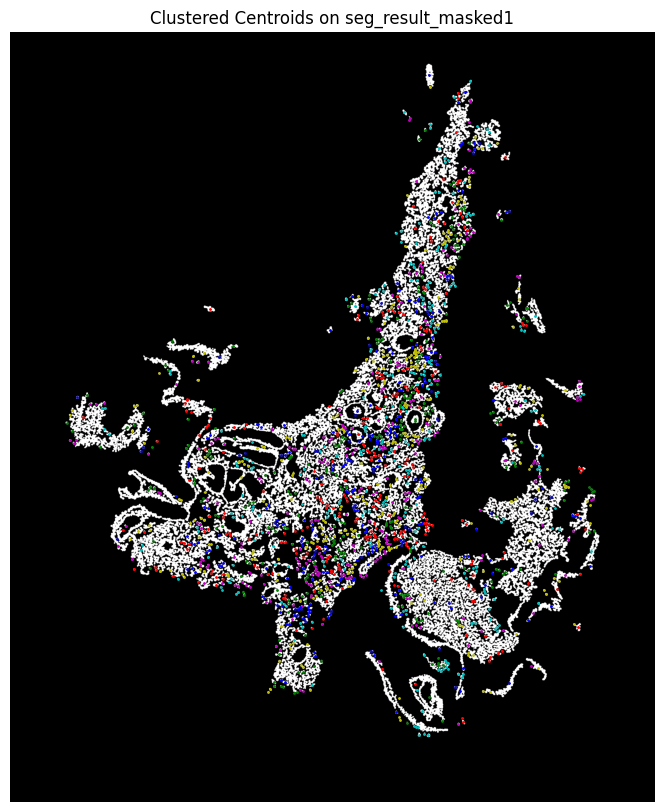

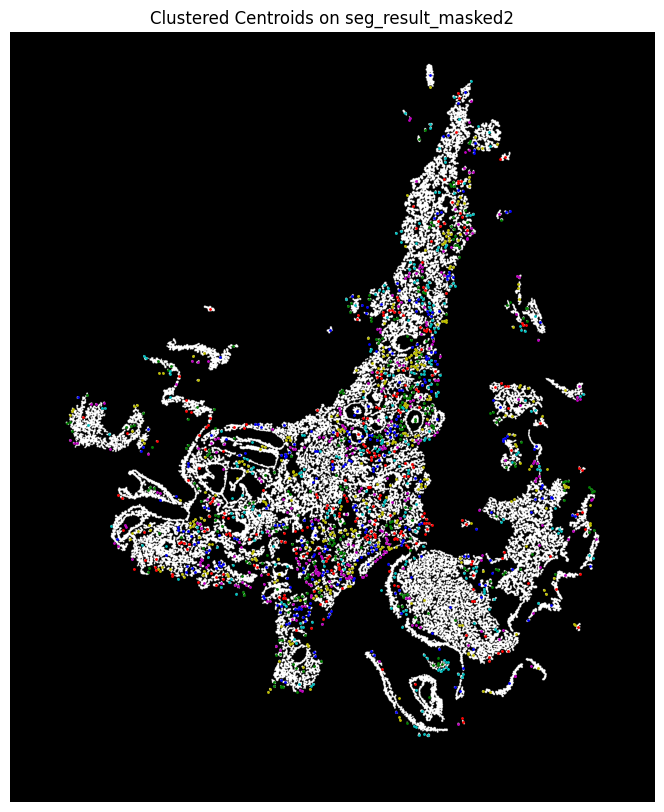

In [47]:
plt.figure(figsize=(10, 10))

# Visualize the seg_result_masked1
plt.imshow(seg_result_masked1, cmap='gray')

# Plot the centroids with different colors for each cluster
colors = ['r', 'g', 'b', 'y', 'c', 'm']  # Add more colors if you have more clusters
for (y, x), label in zip(centroids1, labels_img1):
    plt.scatter(x, y, c=colors[label % len(colors)], s=1)

plt.title('Clustered Centroids on seg_result_masked1')
plt.axis('off')

plt.show()

plt.figure(figsize=(10, 10))

# Visualize the seg_result_masked2
plt.imshow(seg_result_masked2, cmap='gray')

# Plot the centroids with different colors for each cluster
for (y, x), label in zip(centroids2, labels_img2):
    plt.scatter(x, y, c=colors[label % len(colors)], s=1)

plt.title('Clustered Centroids on seg_result_masked2')
plt.axis('off')

plt.show()

In [25]:
# Group the centroids by their cluster labels
clustered_centroids1 = [np.array([centroids1[i] for i in range(len(centroids1)) if labels_img1[i] == label]) for label in range(n_clusters)]
clustered_centroids2 = [np.array([centroids2[i] for i in range(len(centroids2)) if labels_img2[i] == label]) for label in range(n_clusters)]

# Calculate the mean position of each cluster in both images, ensuring that the cluster is not empty
mean_positions1 = [np.mean(cluster, axis=0) for cluster in clustered_centroids1 if cluster.size > 0]
mean_positions2 = [np.mean(cluster, axis=0) for cluster in clustered_centroids2 if cluster.size > 0]

# Ensure that there are mean positions in both images before calculating the mean difference
if mean_positions1 and mean_positions2:
    mean_difference = np.mean([np.abs(pos1 - pos2) for pos1, pos2 in zip(mean_positions1, mean_positions2)])
    print(f"Mean difference between clustered centroids: {mean_difference}")
else:
    print("No centroids found in one or both images.")

Mean difference between clustered centroids: 285.9227684706371


In [26]:
from scipy.spatial.distance import cdist

# Determine which list of centroids is shorter
if len(centroids1) < len(centroids2):
    shorter_centroids, longer_centroids = centroids1, centroids2
else:
    shorter_centroids, longer_centroids = centroids2, centroids1

# Calculate the pairwise distances between the centroids in the two lists
distances = cdist(shorter_centroids, longer_centroids)

# For each centroid in the shorter list, find the minimum distance to a centroid in the longer list
min_distances = np.min(distances, axis=1)

# Calculate the mean of the minimum distances
mean_difference = np.mean(min_distances)

print(f"Mean difference between closest centroids: {mean_difference}")

Mean difference between closest centroids: 7.583836570277022
